<a href="https://colab.research.google.com/github/noerAditama/TA-Kualitas-Beras/blob/master/klasifikasi_kualitas_beras_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install subversion > /dev/null
!svn export https://github.com/noerAditama/TA-Kualitas-Beras/trunk/dataset > /dev/null

svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'dataset' already exists


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

TensorFlow 2.x selected.


In [4]:
!ls dataset/ir64
!ls dataset/ir64/premium
!ls dataset/ir64/medium
!ls dataset/ir64/tidak_layak

medium	premium  tidak_layak
pi_001.jpg  pi_006.jpg	pi_011.jpg  pi_016.jpg	pi_021.jpg
pi_002.jpg  pi_007.jpg	pi_012.jpg  pi_017.jpg	pi_022.jpg
pi_003.jpg  pi_008.jpg	pi_013.jpg  pi_018.jpg	pi_023.jpg
pi_004.jpg  pi_009.jpg	pi_014.jpg  pi_019.jpg	pi_024.jpg
pi_005.jpg  pi_010.jpg	pi_015.jpg  pi_020.jpg	pi_025.jpg
mi_026.jpg  mi_031.jpg	mi_036.jpg  mi_041.jpg	mi_046.jpg
mi_027.jpg  mi_032.jpg	mi_037.jpg  mi_042.jpg	mi_047.jpg
mi_028.jpg  mi_033.jpg	mi_038.jpg  mi_043.jpg	mi_048.jpg
mi_029.jpg  mi_034.jpg	mi_039.jpg  mi_044.jpg	mi_049.jpg
mi_030.jpg  mi_035.jpg	mi_040.jpg  mi_045.jpg	mi_050.jpg
ti_051.jpg  ti_056.jpg	ti_061.jpg  ti_066.jpg	ti_071.jpg
ti_052.jpg  ti_057.jpg	ti_062.jpg  ti_067.jpg	ti_072.jpg
ti_053.jpg  ti_058.jpg	ti_063.jpg  ti_068.jpg	ti_073.jpg
ti_054.jpg  ti_059.jpg	ti_064.jpg  ti_069.jpg	ti_074.jpg
ti_055.jpg  ti_060.jpg	ti_065.jpg  ti_070.jpg	ti_075.jpg


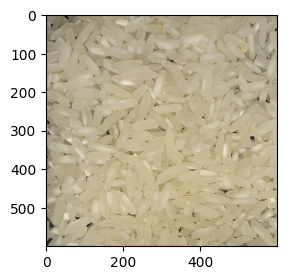

In [5]:
image = imread("dataset/ir64/premium/pi_024.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [6]:
image_size =224
batch_size =128
base_dir =os.path.join('dataset/ir64')
data_gen= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=0.2)
train_gen =data_gen.flow_from_directory(
    base_dir, target_size=(image_size, image_size),
    subset='training')
val_gen = data_gen.flow_from_directory(
    base_dir, target_size=(image_size, image_size),
    subset='validation')

x_test = []
y_test = []
labels = ['premium', 'medium', 'tidak_layak']

for i, label in enumerate(labels):
  folder =os.path.join("dataset/ir64",label)
  files =sorted(os.listdir(folder))
  files =[x for x in files if x.endswith(".jpg")]
  for k,file in enumerate(files):
    image_path =os.path.join(folder, file)
    image = imread(image_path)/255.
    image = resize(image,(244,244))
    x_test.append(image)
    category =os.path.split(folder)[-1]
    y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)
for image_batch, label_batch in train_gen:
  break
print("Bentuk array dari dataset pelatihan adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_gen:
  break
print("Bentuk array dari dataset validasi adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test pengujian adalah:", x_test.shape,y_test.shape)

Found 60 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Bentuk array dari dataset pelatihan adalah: (32, 224, 224, 3) (32, 3)
Bentuk array dari dataset validasi adalah: (15, 224, 224, 3) (15, 3)
Bentuk array dari dataset test pengujian adalah: (75, 244, 244, 3) (75,)


In [7]:
print (train_gen.class_indices)

labels_txt = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)
!cat labels.txt

{'medium': 0, 'premium': 1, 'tidak_layak': 2}
medium
premium
tidak_layak

In [8]:
img_shape = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG-16Net
base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [9]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


Using TensorFlow backend.


In [10]:

#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_gen, 
                    epochs=150, 
                    validation_data=val_gen)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 1 steps
Epoch 1/150
2/2 [==============================] - 39s 20s/step - loss: 1.1903 - acc: 0.3000 - val_loss: 1.1025 - val_acc: 0.4000
Epoch 2/150
2/2 [==============================] - 37s 19s/step - loss: 1.0627 - acc: 0.5500 - val_loss: 1.0244 - val_acc: 0.5333
Epoch 3/150
2/2 [==============================] - 37s 19s/step - loss: 0.9802 - acc: 0.5000 - val_loss: 0.9849 - val_acc: 0.4000
Epoch 4/150
2/2 [==============================] - 37s 19s/step - loss: 0.9235 - acc: 0.5500 - val_loss: 0.9196 - val_acc: 0.6667
Epoch 5/150
2/2 [==============================] - 38s 19s/step - loss: 0.8460 - acc: 0.8333 - val_loss: 0.8671 - val_acc: 0.7333
Epoch 6/150
2/2 [==============================] - 37s 19s/step - loss: 0.7839 - acc: 0.8667 - val_loss: 0.8274 - val_acc: 0.6667
Epoch 7/150
2/2 [==============================] - 38s